# PM2.5 Forecasting with 365-Day Lookback and 90-Day Forecast Using LSTM

This notebook implements a univariate LSTM-based forecasting model for PM2.5 using:
- 365-day lookback window (past year)
- 1.5 year forecast horizon 

Two architectures are compared:
- Seq2Seq LSTM
- Bidirectional Seq2Seq LSTM


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from datetime import timedelta

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2025-05-09 23:12:35.153743: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load and preprocess

In [3]:
df = pd.read_csv('../Data/Final data/df_daily.csv', parse_dates=["date"]) 
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

## Feature engineering

In [5]:
df['pm2.5_lag1'] = df['pm2.5_avg'].shift(1)
df['pm2.5_lag7'] = df['pm2.5_avg'].shift(7)
df['pm2.5_roll7'] = df['pm2.5_avg'].rolling(window=7).mean()
df['pm2.5_std7'] = df['pm2.5_avg'].rolling(window=7).std()
df['pm2.5_roll_min7'] = df['pm2.5_avg'].rolling(window=7).min()
df['pm2.5_roll_max7'] = df['pm2.5_avg'].rolling(window=7).max()

df['month'] = df.index.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['dow'] = df.index.dayofweek
df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)

In [6]:
df.dropna(inplace=True)

## Select features

In [7]:
features = ['pm2.5_avg', 'humidity', 'temperature', 'pressure',
            'pm2.5_lag1', 'pm2.5_lag7', 'pm2.5_roll7', 'pm2.5_std7',
            'pm2.5_roll_min7', 'pm2.5_roll_max7',
            'month_sin', 'month_cos', 'dow_sin', 'dow_cos']

In [8]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])
n_features = len(features)
pm25_index = features.index("pm2.5_avg")

## Sequence generation

In [ ]:

def create_multi_sequences(data, lookback=30, horizon=30):
    X, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+horizon, 0])
    return np.array(X), np.array(y).reshape(-1, horizon, 1)

In [10]:
lookback, horizon = 30, 30
X, y = create_multi_sequences(scaled, lookback, horizon)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

## Define the Model

In [11]:
def build_seq2seq(input_shape, output_steps, bidirectional=True):
    inp = Input(shape=input_shape)
    x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))(inp) if bidirectional else LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))(inp)
    x = Bidirectional(LSTM(64, kernel_regularizer=l2(0.001)))(x) if bidirectional else LSTM(64, kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    x = RepeatVector(output_steps)(x)
    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)))(x) if bidirectional else LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    out = TimeDistributed(Dense(1))(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse')
    return model

In [12]:
model = build_seq2seq((lookback, X.shape[2]), output_steps=horizon, bidirectional=True)
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=16,
          validation_split=0.1, callbacks=[early_stop], verbose=0)

## Model Evaluation

In [13]:
y_pred = model.predict(X_test).flatten()
y_test_flat = y_test.flatten()
dummy_test = np.zeros((len(y_test_flat), n_features))
dummy_test[:, pm25_index] = y_test_flat
y_test_inv = scaler.inverse_transform(dummy_test)[:, pm25_index]
dummy_pred = np.zeros((len(y_pred), n_features))
dummy_pred[:, pm25_index] = y_pred
y_pred_inv = scaler.inverse_transform(dummy_pred)[:, pm25_index]
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
print(f"✅ Test MSE: {mse:.2f}")
print(f"✅ Test RMSE: {rmse:.2f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step
✅ Test MSE: 818.72
✅ Test RMSE: 28.61


The MSE of the bidirectional model is high so we will go forward and update our model for better results.

# Changed Model N1:

In [14]:
# Feature engineering
df['pm2.5_lag1'] = df['pm2.5_avg'].shift(1)
df['pm2.5_lag7'] = df['pm2.5_avg'].shift(7)
df['pm2.5_roll7'] = df['pm2.5_avg'].rolling(window=7).mean()
df['pm2.5_std7'] = df['pm2.5_avg'].rolling(window=7).std()
df['month'] = df.index.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df.dropna(inplace=True)

In [15]:
# Feature selection and scaling
features = ['pm2.5_avg', 'humidity', 'temperature', 'pressure',
            'pm2.5_lag1', 'pm2.5_lag7', 'pm2.5_roll7', 'pm2.5_std7',
            'month_sin', 'month_cos']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])
n_features = len(features)
pm25_index = features.index("pm2.5_avg")


In [16]:
# Create sequences
def create_multi_sequences(data, lookback=30, horizon=30):
    X, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+horizon, 0])
    return np.array(X), np.array(y).reshape(-1, horizon, 1)

lookback, horizon = 30, 30
X, y = create_multi_sequences(scaled, lookback, horizon)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [17]:
# Build model
def build_seq2seq(input_shape, output_steps, bidirectional=False):
    inp = Input(shape=input_shape)
    if bidirectional:
        x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))(inp)
        x = Bidirectional(LSTM(64, kernel_regularizer=l2(0.001)))(x)
    else:
        x = LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))(inp)
        x = LSTM(64, kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    x = RepeatVector(output_steps)(x)
    if bidirectional:
        x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    else:
        x = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    out = TimeDistributed(Dense(1))(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse')
    return model

In [18]:
# Train both models
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

model_seq = build_seq2seq((lookback, X.shape[2]), horizon, bidirectional=False)
model_seq.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[early_stop], verbose=0)

model_bidir = build_seq2seq((lookback, X.shape[2]), horizon, bidirectional=True)
model_bidir.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[early_stop], verbose=0)

In [19]:
# Evaluation function
def evaluate(model, X, y_true):
    y_pred = model.predict(X).flatten()
    y_true = y_true.flatten()
    dummy_pred = np.zeros((len(y_pred), n_features))
    dummy_true = np.zeros((len(y_true), n_features))
    dummy_pred[:, pm25_index] = y_pred
    dummy_true[:, pm25_index] = y_true
    y_pred_inv = scaler.inverse_transform(dummy_pred)[:, pm25_index]
    y_true_inv = scaler.inverse_transform(dummy_true)[:, pm25_index]
    mse = mean_squared_error(y_true_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    return y_true_inv, y_pred_inv, mse, rmse

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step
🔵 Seq2Seq  MSE: 753.15, RMSE: 27.44
🟢 BiLSTM   MSE: 820.01, RMSE: 28.64


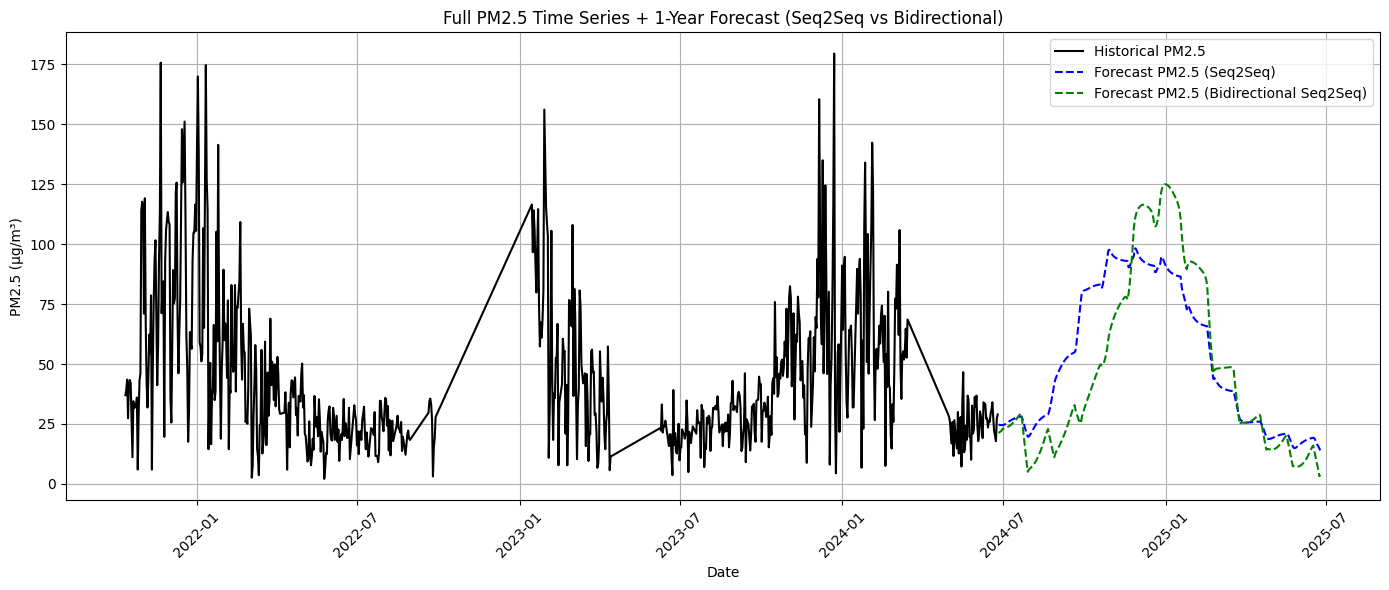

In [ ]:
# Evaluate both models

y_true_inv, y_pred_seq_inv, mse_seq, rmse_seq = evaluate(model_seq, X_test, y_test)
_, y_pred_bidir_inv, mse_bidir, rmse_bidir = evaluate(model_bidir, X_test, y_test)

print(f"🔵 Seq2Seq  MSE: {mse_seq:.2f}, RMSE: {rmse_seq:.2f}")
print(f"🟢 BiLSTM   MSE: {mse_bidir:.2f}, RMSE: {rmse_bidir:.2f}")

# Forecast function
def forecast_future(model, input_seq, forecast_days):
    future_preds = []
    curr_date = df.index[-1]
    for _ in range(forecast_days):
        input_reshaped = input_seq.reshape(1, lookback, -1)
        next_preds = model.predict(input_reshaped, verbose=0)[0, :, 0]
        for val in next_preds:
            if len(future_preds) >= forecast_days:
                break
            curr_date += timedelta(days=1)
            month_sin = np.sin(2 * np.pi * curr_date.month / 12)
            month_cos = np.cos(2 * np.pi * curr_date.month / 12)
            last_row = input_seq[-1]
            humidity, temp, press = last_row[1], last_row[2], last_row[3]
            next_input = np.array([val, humidity, temp, press, val, val, val, val, month_sin, month_cos])
            input_seq = np.vstack([input_seq[1:], next_input])
            future_preds.append(next_input)
    return np.array(future_preds)

# Forecast 365 days
forecast_days = 365
input_seq = scaled[-lookback:].copy()
future_preds_seq = forecast_future(model_seq, input_seq.copy(), forecast_days)
future_preds_bidir = forecast_future(model_bidir, input_seq.copy(), forecast_days)

# Inverse transform
def inverse_pm25(preds_array):
    dummy_input = np.zeros((forecast_days, n_features))
    dummy_input[:, pm25_index] = preds_array[:, 0]
    return scaler.inverse_transform(dummy_input)[:, pm25_index]

future_pm25_seq = inverse_pm25(future_preds_seq)
future_pm25_bidir = inverse_pm25(future_preds_bidir)

# Smooth
future_pm25_seq = pd.Series(future_pm25_seq).rolling(window=7, min_periods=1, center=True).mean().clip(0, 500).values
future_pm25_bidir = pd.Series(future_pm25_bidir).rolling(window=7, min_periods=1, center=True).mean().clip(0, 500).values

# Plot
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_days)
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['pm2.5_avg'], label='Historical PM2.5', color='black')
plt.plot(future_dates, future_pm25_seq, label='Forecast PM2.5 (Seq2Seq)', linestyle='dashed', color='blue')
plt.plot(future_dates, future_pm25_bidir, label='Forecast PM2.5 (Bidirectional Seq2Seq)', linestyle='dashed', color='green')
plt.title("Full PM2.5 Time Series + 1-Year Forecast (Seq2Seq vs Bidirectional)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Better performed model N2: 

In [ ]:
# Feature engineering
df['pm2.5_lag1'] = df['pm2.5_avg'].shift(1)
df['pm2.5_lag7'] = df['pm2.5_avg'].shift(7)
df['pm2.5_roll7'] = df['pm2.5_avg'].rolling(window=7).mean()
df['pm2.5_std7'] = df['pm2.5_avg'].rolling(window=7).std()
df['month'] = df.index.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df.dropna(inplace=True)

In [ ]:
# Feature selection and scaling
features = ['pm2.5_avg', 'humidity', 'temperature', 'pressure',
            'pm2.5_lag1', 'pm2.5_lag7', 'pm2.5_roll7', 'pm2.5_std7',
            'month_sin', 'month_cos']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])
n_features = len(features)
pm25_index = features.index("pm2.5_avg")


In [ ]:
# Create sequences
def create_multi_sequences(data, lookback=90, horizon=30):
    X, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+horizon, 0])
    return np.array(X), np.array(y).reshape(-1, horizon, 1)

lookback, horizon = 365, 30
X, y = create_multi_sequences(scaled, lookback, horizon)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
# Build model
def build_seq2seq(input_shape, output_steps, bidirectional=False):
    inp = Input(shape=input_shape)
    if bidirectional:
        x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))(inp)
        x = Bidirectional(LSTM(64, kernel_regularizer=l2(0.001)))(x)
    else:
        x = LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))(inp)
        x = LSTM(64, kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    x = RepeatVector(output_steps)(x)
    if bidirectional:
        x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    else:
        x = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    out = TimeDistributed(Dense(1))(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
# Train both models
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

model_seq = build_seq2seq((lookback, X.shape[2]), horizon, bidirectional=False)
model_seq.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[early_stop], verbose=0)

model_bidir = build_seq2seq((lookback, X.shape[2]), horizon, bidirectional=True)
model_bidir.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[early_stop], verbose=0)


In [ ]:
# Evaluation function
def evaluate(model, X, y_true):
    y_pred = model.predict(X).flatten()
    y_true = y_true.flatten()
    dummy_pred = np.zeros((len(y_pred), n_features))
    dummy_true = np.zeros((len(y_true), n_features))
    dummy_pred[:, pm25_index] = y_pred
    dummy_true[:, pm25_index] = y_true
    y_pred_inv = scaler.inverse_transform(dummy_pred)[:, pm25_index]
    y_true_inv = scaler.inverse_transform(dummy_true)[:, pm25_index]
    mse = mean_squared_error(y_true_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    return y_true_inv, y_pred_inv, mse, rmse

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 634ms/step
🔵 Seq2Seq  MSE: 437.21, RMSE: 20.91
🟢 BiLSTM   MSE: 372.09, RMSE: 19.29


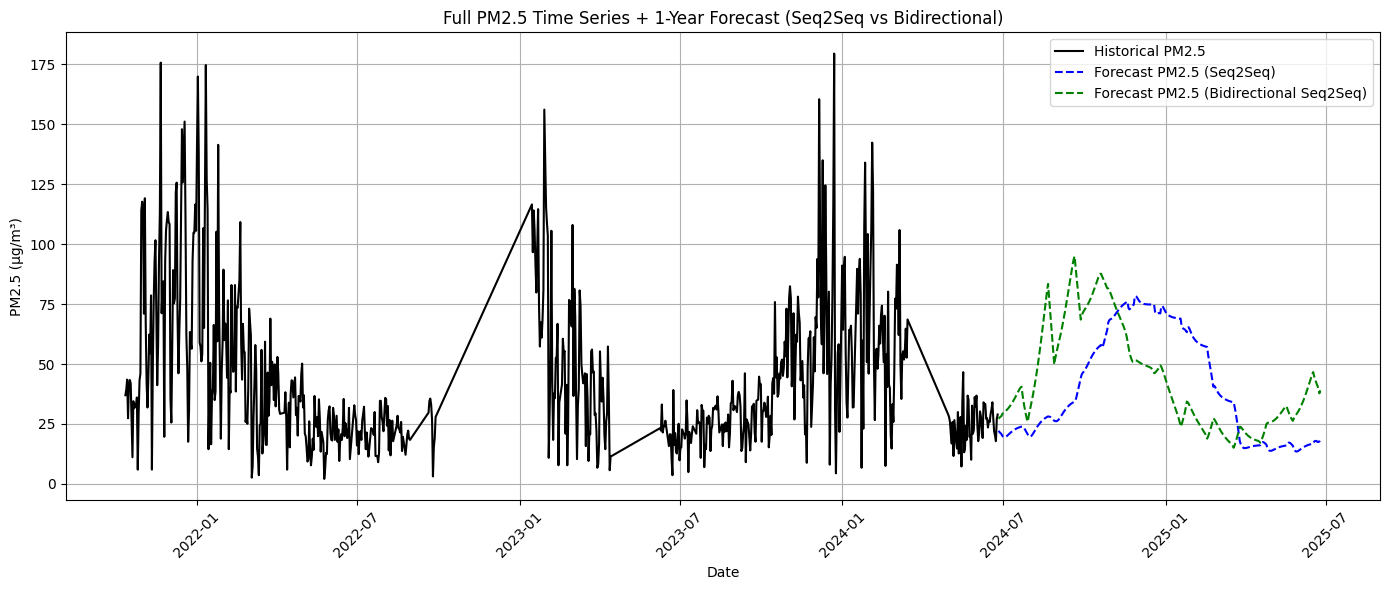

In [ ]:
# Evaluate both models

y_true_inv, y_pred_seq_inv, mse_seq, rmse_seq = evaluate(model_seq, X_test, y_test)
_, y_pred_bidir_inv, mse_bidir, rmse_bidir = evaluate(model_bidir, X_test, y_test)

print(f"🔵 Seq2Seq  MSE: {mse_seq:.2f}, RMSE: {rmse_seq:.2f}")
print(f"🟢 BiLSTM   MSE: {mse_bidir:.2f}, RMSE: {rmse_bidir:.2f}")

# Forecast function
def forecast_future(model, input_seq, forecast_days):
    future_preds = []
    curr_date = df.index[-1]
    for _ in range(forecast_days):
        input_reshaped = input_seq.reshape(1, lookback, -1)
        next_preds = model.predict(input_reshaped, verbose=0)[0, :, 0]
        for val in next_preds:
            if len(future_preds) >= forecast_days:
                break
            curr_date += timedelta(days=1)
            month_sin = np.sin(2 * np.pi * curr_date.month / 12)
            month_cos = np.cos(2 * np.pi * curr_date.month / 12)
            last_row = input_seq[-1]
            humidity, temp, press = last_row[1], last_row[2], last_row[3]
            next_input = np.array([val, humidity, temp, press, val, val, val, val, month_sin, month_cos])
            input_seq = np.vstack([input_seq[1:], next_input])
            future_preds.append(next_input)
    return np.array(future_preds)

# Forecast 365 days
forecast_days = 365
input_seq = scaled[-lookback:].copy()
future_preds_seq = forecast_future(model_seq, input_seq.copy(), forecast_days)
future_preds_bidir = forecast_future(model_bidir, input_seq.copy(), forecast_days)

# Inverse transform
def inverse_pm25(preds_array):
    dummy_input = np.zeros((forecast_days, n_features))
    dummy_input[:, pm25_index] = preds_array[:, 0]
    return scaler.inverse_transform(dummy_input)[:, pm25_index]

future_pm25_seq = inverse_pm25(future_preds_seq)
future_pm25_bidir = inverse_pm25(future_preds_bidir)

# Smooth
future_pm25_seq = pd.Series(future_pm25_seq).rolling(window=7, min_periods=1, center=True).mean().clip(0, 500).values
future_pm25_bidir = pd.Series(future_pm25_bidir).rolling(window=7, min_periods=1, center=True).mean().clip(0, 500).values

# Plot
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_days)
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['pm2.5_avg'], label='Historical PM2.5', color='black')
plt.plot(future_dates, future_pm25_seq, label='Forecast PM2.5 (Seq2Seq)', linestyle='dashed', color='blue')
plt.plot(future_dates, future_pm25_bidir, label='Forecast PM2.5 (Bidirectional Seq2Seq)', linestyle='dashed', color='green')
plt.title("Full PM2.5 Time Series + 1-Year Forecast (Seq2Seq vs Bidirectional)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# The Best model for 1.5 year forecast

In [20]:
# Feature engineering
df['pm2.5_lag1'] = df['pm2.5_avg'].shift(1)
df['pm2.5_lag7'] = df['pm2.5_avg'].shift(7)
df['pm2.5_roll7'] = df['pm2.5_avg'].rolling(window=7).mean()
df['pm2.5_std7'] = df['pm2.5_avg'].rolling(window=7).std()
df['month'] = df.index.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df.dropna(inplace=True)

In [21]:
# Feature selection and scaling
features = ['pm2.5_avg', 'humidity', 'temperature', 'pressure',
            'pm2.5_lag1', 'pm2.5_lag7', 'pm2.5_roll7', 'pm2.5_std7',
            'month_sin', 'month_cos']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])
n_features = len(features)
pm25_index = features.index("pm2.5_avg")

In [22]:
# Create sequences
def create_multi_sequences(data, lookback=90, horizon=30):
    X, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+horizon, 0])
    return np.array(X), np.array(y).reshape(-1, horizon, 1)

In [23]:
lookback, horizon = 365, 20
X, y = create_multi_sequences(scaled, lookback, horizon)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [24]:
# Build model
def build_seq2seq(input_shape, output_steps, bidirectional=False):
    inp = Input(shape=input_shape)
    if bidirectional:
        x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))(inp)
        x = Bidirectional(LSTM(64, kernel_regularizer=l2(0.001)))(x)
    else:
        x = LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))(inp)
        x = LSTM(64, kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    x = RepeatVector(output_steps)(x)
    if bidirectional:
        x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    else:
        x = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    out = TimeDistributed(Dense(1))(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
# Train both models
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

model_seq = build_seq2seq((lookback, X.shape[2]), horizon, bidirectional=False)
model_seq.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[early_stop], verbose=0)

model_bidir = build_seq2seq((lookback, X.shape[2]), horizon, bidirectional=True)
model_bidir.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[early_stop], verbose=0)

In [ ]:
# Evaluation function
def evaluate(model, X, y_true):
    y_pred = model.predict(X).flatten()
    y_true = y_true.flatten()
    dummy_pred = np.zeros((len(y_pred), n_features))
    dummy_true = np.zeros((len(y_true), n_features))
    dummy_pred[:, pm25_index] = y_pred
    dummy_true[:, pm25_index] = y_true
    y_pred_inv = scaler.inverse_transform(dummy_pred)[:, pm25_index]
    y_true_inv = scaler.inverse_transform(dummy_true)[:, pm25_index]
    mse = mean_squared_error(y_true_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    return y_true_inv, y_pred_inv, mse, rmse

In [ ]:
# Evaluate both
y_true_inv, y_pred_seq_inv, mse_seq, rmse_seq = evaluate(model_seq, X_test, y_test)
_, y_pred_bidir_inv, mse_bidir, rmse_bidir = evaluate(model_bidir, X_test, y_test)

print(f"🔵 Seq2Seq  MSE: {mse_seq:.2f}, RMSE: {rmse_seq:.2f}")
print(f"🟢 BiLSTM   MSE: {mse_bidir:.2f}, RMSE: {rmse_bidir:.2f}")

In [ ]:

# Forecast function
def forecast_future(model, input_seq, forecast_days):
    future_preds = []
    curr_date = df.index[-1]
    for _ in range(forecast_days):
        input_reshaped = input_seq.reshape(1, lookback, -1)
        next_preds = model.predict(input_reshaped, verbose=0)[0, :, 0]
        for val in next_preds:
            if len(future_preds) >= forecast_days:
                break
            curr_date += timedelta(days=1)
            month_sin = np.sin(2 * np.pi * curr_date.month / 12)
            month_cos = np.cos(2 * np.pi * curr_date.month / 12)
            last_row = input_seq[-1]
            humidity, temp, press = last_row[1], last_row[2], last_row[3]
            next_input = np.array([val, humidity, temp, press, val, val, val, val, month_sin, month_cos])
            input_seq = np.vstack([input_seq[1:], next_input])
            future_preds.append(next_input)
    return np.array(future_preds)

In [ ]:
# Forecast 913 days
forecast_days = 913
input_seq = scaled[-lookback:].copy()
future_preds_seq = forecast_future(model_seq, input_seq.copy(), forecast_days)
future_preds_bidir = forecast_future(model_bidir, input_seq.copy(), forecast_days)

In [ ]:
# Inverse transform
def inverse_pm25(preds_array):
    dummy_input = np.zeros((forecast_days, n_features))
    dummy_input[:, pm25_index] = preds_array[:, 0]
    return scaler.inverse_transform(dummy_input)[:, pm25_index]

future_pm25_seq = inverse_pm25(future_preds_seq)
future_pm25_bidir = inverse_pm25(future_preds_bidir)

In [ ]:
# Smooth
future_pm25_seq = pd.Series(future_pm25_seq).rolling(window=7, min_periods=1, center=True).mean().clip(0, 500).values
future_pm25_bidir = pd.Series(future_pm25_bidir).rolling(window=7, min_periods=1, center=True).mean().clip(0, 500).values


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 496ms/step
🔵 Seq2Seq  MSE: 563.07, RMSE: 23.73
🟢 BiLSTM   MSE: 276.50, RMSE: 16.63


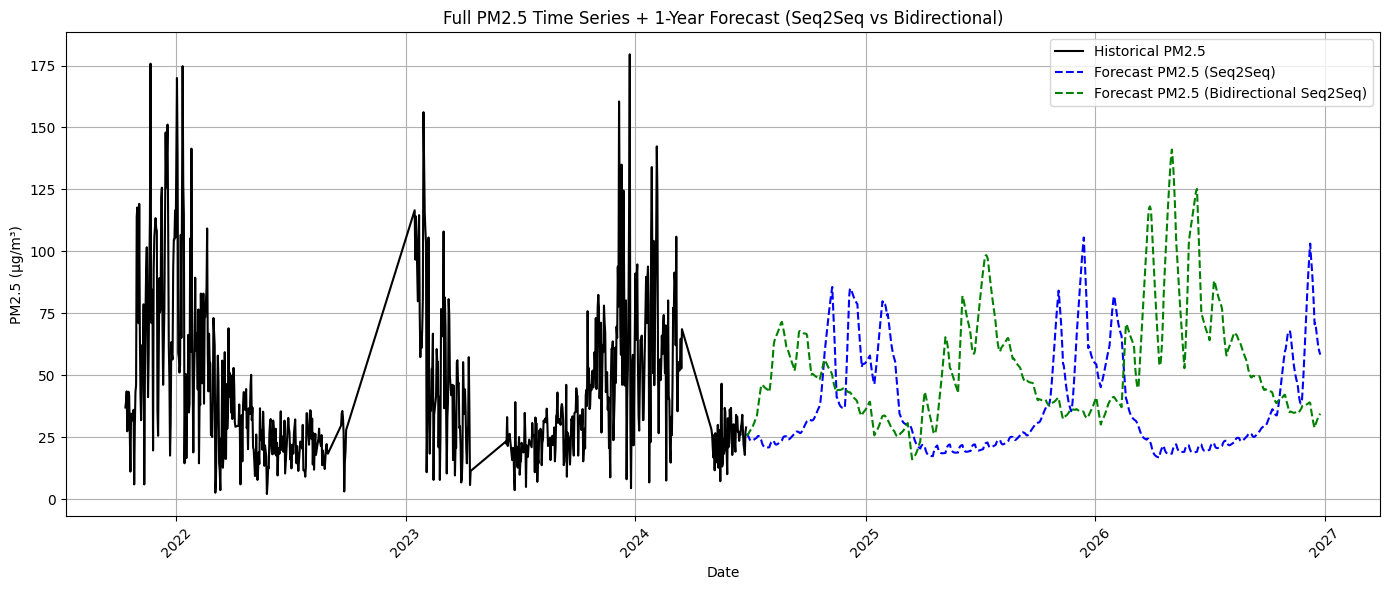

In [ ]:
# Plot
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_days)
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['pm2.5_avg'], label='Historical PM2.5', color='black')
plt.plot(future_dates, future_pm25_seq, label='Forecast PM2.5 (Seq2Seq)', linestyle='dashed', color='blue')
plt.plot(future_dates, future_pm25_bidir, label='Forecast PM2.5 (Bidirectional Seq2Seq)', linestyle='dashed', color='green')
plt.title("Full PM2.5 Time Series + 1-Year Forecast (Seq2Seq vs Bidirectional)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()